In [1]:
import numpy as np
import matplotlib.pyplot as plt

from include.load_data.get_counts import get_real_counts_by_county


from include.build_synth import buildData_fromRO as build

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE
from include.estim import Rt_L



from importlib import reload
reload(RtM), reload(LL)

np.random.seed(2025)

## Disconnected complete graphs (french departments)
Define spatial clusters as disconnected complete graphs, with equal reproduction number in each cluster

In [2]:
firstDay, lastDay = "2020-12-01", "2021-02-10"
dataBasis = 'SPF'
country = "France"
allZData, options = get_real_counts_by_county(firstDay, lastDay, dataBasis)


In [3]:
names_by_clusters = [["22","29","56"],["40","64","65"],["38","73","74"]] # bretagne/ pyrénées ouest / alpes
# names_by_clusters = [["85","17","79"],["62","59","80"],["70","25","39"]] # vendée / Nord / Franche comté

cluster_sizes = [len(cluster) for cluster in names_by_clusters]
nclusters = len(names_by_clusters)

ZData = []
#extract data by depts
for cluster in names_by_clusters:
    for name in cluster:
        id = int(np.where(options["counties"]==name)[0][0])
        ZData.append(allZData[id])
ZData = np.array(ZData)


if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))


## Generate ZData 
For each country, we generate new cases counts according to the reproduction number of their cluster

First day : 2020-12-01 
 Last day : 2021-02-10


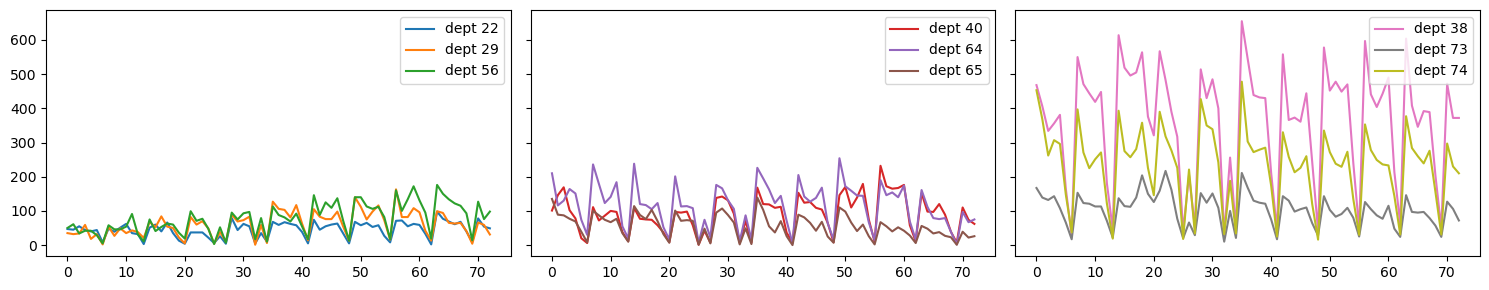

In [4]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True, sharey="row")
k = 0
for i in range(len(cluster_sizes)):
    for j in range(cluster_sizes[i]):
        axs[i].plot(ZData[k], color=colors[k], label="dept "+names_by_clusters[i][j])
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [5]:
# get R estim with O as a reference
# RestimUO = Rt_U_O(ZData, 3.5, 0.03, options=options)

In [7]:
reload(Rt_L)

n_max_iter = 5

#init param
init_method = "U"
init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GRs = [ [1.] , [0.1, 0.5, 1.], [0.1, 0.4, 0.7, 1.], [0.1, 0.4, 0.7, 0.85, 1.] ]
lambda_pwlin = 20

various_Rs, various_Ls, various_objs = [], [], []
for lambda_GR in lambda_GRs:
    Restims, Lestims, _, objs = Rt_L.Rt_L(ZData, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)
    various_Rs.append(Restims), various_Ls.append(Lestims), various_objs.append(objs)



Computing Univariate estimator ...
Done in 9.1479 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 28.6196 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 31.7101 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 28.9003 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 28.0867 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 28.3015 seconds ---
Computing Univariate estimator ...
Done in 8.5721 seconds ---
lambda_GR = 0.100
Computing Multivariate estimator ...
Done in 33.5718 seconds ---
lambda_GR = 0.500
Computing Multivariate estimator ...
Done in 38.6738 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 33.5872 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 37.6456 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 35.4601 seconds ---
Computing Univariate estimator ...
Done in 11.

In [8]:
various_objs = np.array(various_objs)

n_scenario = various_objs.shape[0]
i_opt = np.argmin(various_objs)
scenario_opt, iter_opt = i_opt//(n_max_iter+1), i_opt%(n_max_iter+1)
Lref, Rref = various_Ls[scenario_opt][iter_opt], various_Rs[scenario_opt][iter_opt]

Lerrors = np.zeros((n_scenario, n_max_iter+1))
Rerrors = np.zeros((n_scenario, n_max_iter+1))
for sc in range(n_scenario):
    for iter in range(n_max_iter+1):
        sqLref = np.sum(Lref**2)
        sqRref = np.sum(Rref**2)
        Lerrors[sc, iter] = np.sum((various_Ls[sc][iter] - Lref)**2) / sqLref
        Rerrors[sc, iter] = np.sum((various_Rs[sc][iter] - Rref)**2) / sqRref

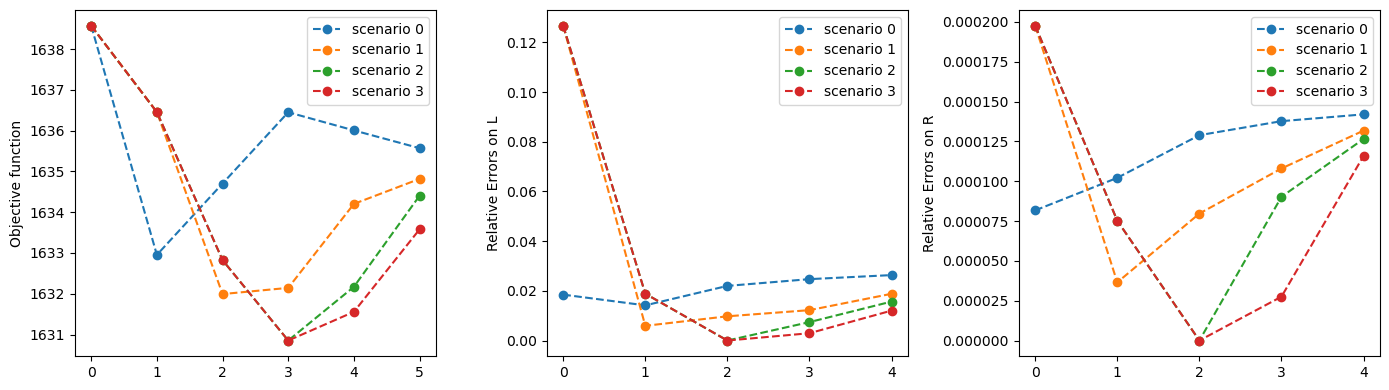

In [17]:
fig, axs = plt.subplots(1,3,figsize=(14,4))

axs[0].plot(various_objs.T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[0].set_ylabel("Objective function")
axs[0].legend()

axs[1].plot(Lerrors[:,1:].T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[1].set_ylabel("Relative Errors on L")
axs[1].legend()


axs[2].plot(Rerrors[:,1:].T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[2].set_ylabel("Relative Errors on R")
axs[2].legend()

plt.tight_layout()

In [13]:
sc = 0
Lestims = various_Ls[sc]
Restims = various_Rs[sc]

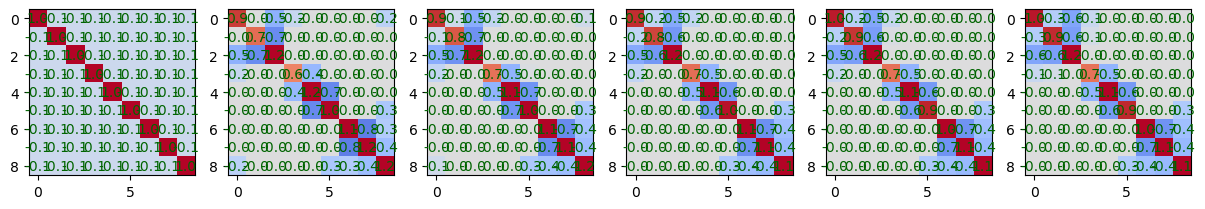

In [14]:
n = Lestims[0].shape[0]
fig, axs = plt.subplots(1, n_max_iter+1, figsize=(15,5), squeeze=False)
for L, ax in zip(Lestims, axs[0]):
    ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
    for i in range(n):
        for j in range(n):
            c = L[i,j]
            ax.text(i, j, "{:2.1f}".format(c), va='center', ha='center', color="darkgreen")

In [ ]:
fig, axs = plt.subplots(n_max_iter+1, nclusters, figsize=(10,10), sharex=True, sharey="row", squeeze=False)
for i in range(n_max_iter+1):
    k = 0
    for j in range(nclusters):
        for l in range(cluster_sizes[j]):
            axs[i,j].plot(Restims[i][k], color=colors[k], label="dept "+names_by_clusters[j][l])
            # axs[i,j].plot(Restims[i][k], ':', color=colors[k])
            # if i == 0:
            #     axs[i,j].plot(RestimUO[i][k], "--", color=colors[k])
            k+=1
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iteration {}".format(i), fontsize=12)
plt.show()

NameError: name 'plt' is not defined

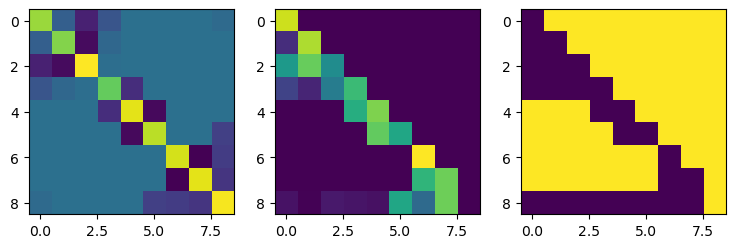

In [75]:
L = Lestims[3]
U = np.linalg.cholesky(L + (1e-12)*np.eye(L.shape[0]))
# plt.imshow( np.abs(U)<1e-10  )
fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(L)
axs[1].imshow(np.abs(U))
axs[2].imshow(np.abs(U)/np.max(U)<1e-3)